In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
"""
データセットの確認
"""
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(" ",X_train.shape) # (60000, 28, 28)
print(" ",X_test.shape) # (10000, 28, 28)
print(" ",X_train[0].dtype) # uint8

  (60000, 28, 28)
  (10000, 28, 28)
  uint8


In [3]:
"""
平滑化
"""
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

print(" ",X_train.shape) # (60000, 784)
print(" ",X_test.shape) # (10000, 784)
print(" ",X_train[0].dtype) # uint8

  (60000, 784)
  (10000, 784)
  uint8


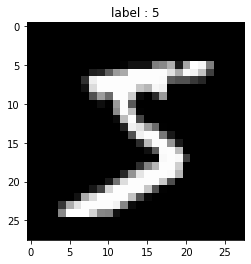

In [4]:
"""
画像データの可視化
"""
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray', vmin = 0, vmax = 255)
plt.title('label : {}'.format(y_train[index]))
plt.show()

In [5]:
"""
前処理
"""
# 0から255のuint8型で表される画像データを0から1のfloat型に変換
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print("",X_train.max()) # 1.0
print("",X_train.min()) # 0.0

 1.0
 0.0


In [6]:
# 正解ラベルをone-hot表現に変換
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print("", y_train.shape) # (60000,)
print("", y_train_one_hot.shape) # (60000, 10)
print("", y_train_one_hot.dtype) # float64

 (60000,)
 (60000, 10)
 float64


In [7]:
# 訓練データ6万枚の内2割を検証データとして分割(訓練データが48000枚、検証データが12000枚)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print("", X_train.shape) # (48000, 784)
print("", X_val.shape) # (12000, 784)

 (48000, 784)
 (12000, 784)


***ニューラルネットワークスクラッチ***

In [8]:
# ミニバッチ処理
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [9]:
class ScratchSimpleNeuralNetrowkClassifier():
    
    SIGMOID, TAN_H = 0, 1 # 使用する活性化関数を識別するための定数
    
    """
    シンプルな三層ニューラルネットワーク分類器
    ----------
    alpha : 学習率
    n_epochs : エポック数
    activation_function_flg : 活性化関数フラグ（０＝シグモイド関数、１＝ハイパボリックタンジェント関数）
    sigma : ガウス分布の標準偏差
    verbose : Trueの場合、学習曲線をプロット
    ----------
    """
    def __init__(self, alpha = 0.01, n_epochs = 30, activation_function_flg = 1, sigma = 0.01, verbose = True):
        
        self.alpha = alpha
        self.n_epochs = n_epochs
        self.verbose = verbose
        self.activation_function_flg = activation_function_flg
        self.sigma = sigma
        
        self.n_nodes1, self.n_nodes2, self.n_output = 400, 200, 10 # 各層のノード数
        self.batch_size = 20 # バッチサイズ
        
        self.n_features = None # 特徴量の数
        self.w1, self.w2, self.w3 = None, None, None # 重み
        self.b1, self.b2, self.b3 = None, None, None # バイアス
        self.a1, self.a2, self.a3 = None, None, None # 出力
        self.z1, self.z2, self.z3 = None, None, None # 出力（活性化後）
    
    """
    ニューラルネットワーク分類器を学習する。
    ----------
    X : 訓練データの特徴量
    y : 訓練データの正解値
    X_val : 検証データの特徴量
    y_val : 検証データの正解値
    """
    def fit(self, X, y, X_val=None, y_val=None):

        # クラス変数の設定
        self.n_features = X.shape[1] # 特徴量の数
        # 重みの初期値を設定（ランダム）
        self.w1 = self._get_ini_w(self.n_features, self.n_nodes1) # (784, 400)
        self.w2 = self._get_ini_w(self.n_nodes1, self.n_nodes2) # (400, 200)
        self.w3 = self._get_ini_w(self.n_nodes2, self.n_output) # (200, １０)
        # バイアスの初期値を設定
        self.b1 = np.ones((self.n_nodes1))# (400, )
        self.b2 = np.ones((self.n_nodes2)) # (200, )
        self.b3 = np.ones((self.n_output)) # (10, )
        # 学習過程出力用の変数の設定
        val_is_None = X_val is None
        train_loss_list = np.zeros((self.n_epochs))
        val_loss_list = np.zeros((self.n_epochs))
        
        # エポック数分繰り返す
        for i in range(self.n_epochs):
            
            # ミニバッチ取得
            get_mini_batch = GetMiniBatch(X, y, self.batch_size)
            # ミニバッチの個数分ループ
            for mini_X_train, mini_y_train in get_mini_batch:
            
                # フォワードプロバゲーション
                self._forward_propagation(mini_X_train)
                # one-hot 表現に変換
                mini_y_one_hot = self._convert_one_hot(mini_y_train)
                # 誤差を算出
                loss = self._get_loss(mini_y_one_hot)
                # バックプロパゲーション
                self._back_propagation(mini_X_train, mini_y_one_hot, loss)
            
            # 検証用データが存在する場合
            if not(val_is_None):
                # フォワードプロバゲーション
                self._forward_propagation(X_val) # ロスを算出する際に使用するself.z3の値が更新される
                # 誤差を記録（バリデーションデータ）
                val_loss_list[i] = self._get_loss(self._convert_one_hot(y_val))
            # 誤差を記録（トレインデータ）
            train_loss_list[i] = loss
            
        # verboseをTrueにした際は学習過程などを出力する
        if self.verbose:
            
            plt.plot(range(self.n_epochs), train_loss_list, color='r', label='train_loss')
            if not(val_is_None):
                plt.plot(range(self.n_epochs), val_loss_list, color='b', label='val_loss')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.show()
    
    """
    【問題2】フォワードプロパゲーションの実装
    """
    def _forward_propagation(self, X):
        
        # 一層目の処理
        self.a1 = X@self.w1 + self.b1
        self.z1 = self._activation(self.a1)
        # 二層目の処理
        self.a2 = self.z1@self.w2 + self.b2
        self.z2 = self._activation(self.a2)
        # 三層目の処理
        self.a3 = self.z2@self.w3 + self.b3
        self.z3 = self._softmax(self.a3)
        
        return self.z3
    
    """
    【問題4】バックプロパゲーションの実装
    """
    def _back_propagation(self, X, y_one_hot, loss):
        
        # 三層目の処理
        a3_grad = (self.z3 - y_one_hot) / self.batch_size
        self.w3 -= self.alpha * self.z2.T.dot(a3_grad)
        self.b3 -= self.alpha * a3_grad.sum(axis=0)
        # 二層目の処理
        z2_grad = a3_grad.dot(self.w3.T)
        a2_grad = z2_grad * (1 - self.z2 ** 2)
        self.w2 -= self.alpha * self.z1.T.dot(a2_grad)
        self.b2 -= self.alpha * a2_grad.sum(axis=0)
        # 一層目の処理
        z1_grad = a2_grad.dot(self.w2.T)
        a1_grad = z1_grad * (1 - self.z1 ** 2)
        self.w1 -= self.alpha * X.T.dot(a1_grad)
        self.b1 -= self.alpha * a1_grad.sum(axis=0)
    
    """
    one-hot表現に変換するメソッド
    """
    def _convert_one_hot(self, y):
        return (y.reshape(-1, 1) == np.arange(self.n_output)).astype(np.float64)
    
    """
    【問題3】交差エントロピー誤差の実装
    損失関数（目的関数）:交差エントロピー誤差
    """
    def _get_loss(self, y_one_hot):
        return -(y_one_hot * np.log(self.z3)).mean(axis=0).sum()
    
    """
    活性化関数
    """
    def _activation(self, a):
        
        # シグモイド関数の場合
        if self.SIGMOID == self.activation_function_flg:
            z = 1/(1+np.exp(-1*a))
            
        # ハイパボリックタンジェントの場合（本来は入力チェックすべきだが、面倒臭いから一旦なし）
        else: # elif self.TAN_H == self.activation_function_flg:
            z = np.tanh(a)
        
        return z
    
    """
    ソフトマックス関数
    """
    def _softmax(self, a):
        a = a - np.max(a, axis=-1, keepdims=True) # オーバーフロー対策
        return np.exp(a) / np.sum(np.exp(a), axis=-1, keepdims=True)
        
    """
    【問題1】重みの初期値を決めるコードの作成
    """
    def _get_ini_w(self, n_features, n_nodes):
        return self.sigma * np.random.randn(n_features, n_nodes) # shape(n_features, n_nodes)
    
    """
    【問題5】推定
    """
    def predict(self, X):
        return self._forward_propagation(X).argmax(axis=1)

In [10]:
"""
【問題6】学習と推定
"""
scr_nn = ScratchSimpleNeuralNetrowkClassifier(verbose = False) # インスタンス生成
scr_nn.fit(X_train, y_train) # 学習
y_pred = scr_nn.predict(X_val) # 推定
# Accuracyを計算
from sklearn.metrics import accuracy_score
print("   accuracy_score : ", accuracy_score(y_val, y_pred))

   accuracy_score :  0.9654166666666667


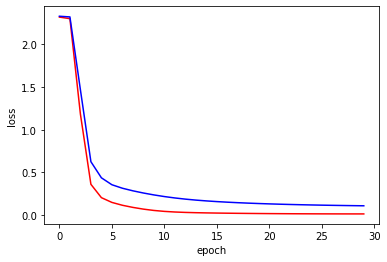

In [11]:
"""
【問題7】学習曲線のプロット
"""
scr_nn = ScratchSimpleNeuralNetrowkClassifier()
scr_nn.fit(X_train, y_train, X_val, y_val)

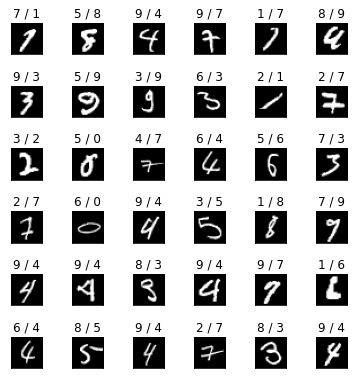

In [12]:
"""
【問題8】（アドバンス課題）誤分類の確認

語分類結果を並べて表示する。画像の上の表示は「推定結果/正解」である。
Parameters:
----------
y_pred : 推定値のndarray (n_samples,)
y_val : 検証データの正解ラベル(n_samples,)
X_val : 検証データの特徴量（n_samples, n_features)
"""
import numpy as np
import matplotlib.pyplot as plt
num = 36 # いくつ表示するか

true_false = y_pred==y_val
false_list = np.where(true_false==False)[0].astype(np.int)
if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(y_pred[false_list[i]],y_val[false_list[i]]))
    ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')